In [32]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdft.dft1d import dft_core
from cdft.lj_eos import lj_eos

torch.set_default_dtype(torch.float64)
device = torch.device('cpu')

pi = np.pi
kB = 1.380649e-23
NA = 6.02214076e23

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
})

colors = sns.color_palette("mako")

In [33]:
sigma = 3.615
epsilon = 101.5
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [34]:
T = 77.4
eos = lj_eos(parameters, T)
P = torch.hstack((torch.logspace(-7,-1,10*6), torch.arange(0.11,0.3,0.01), torch.arange(0.3,1.0,0.1)))*1e5

bulk_density = torch.empty_like(P)

bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_46150/1789170785.py:1: SyntaxWarning: invalid escape sequence '\s'
  nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1,


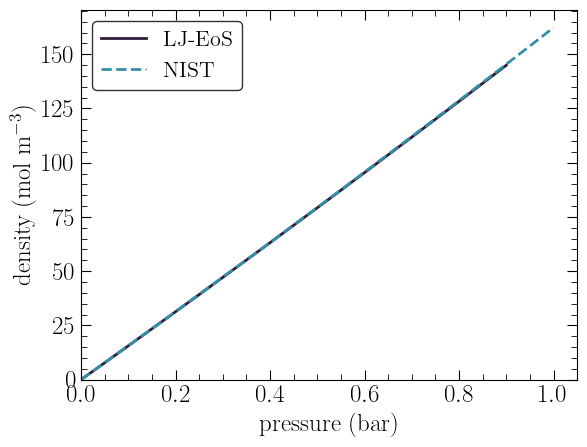

In [35]:
nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1, 
                    usecols=[1,2], names=['Pressure (bar)','Density (mol/m3)'])

colors = sns.color_palette("mako")

plt.plot(P*1e-5, bulk_density*1e30/(NA), '-', color=colors[0], linewidth=2.0, label='LJ-EoS')
plt.plot(nist['Pressure (bar)'],nist['Density (mol/m3)'], '--', color=colors[3], linewidth=2.0, label='NIST')
plt.xlabel(r'pressure (bar)', fontsize=18)
plt.ylabel(r'density (mol m$^{-3}$)', fontsize=18)
plt.xlim([0.0,None])
plt.ylim([0.0,None])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [36]:
H = 20.0
system_size = H+10
points = int(system_size*100)

def steele(z,sigma,epsilon):
    rhos = 0.114
    Delta = 3.35
    return 2.0*pi*rhos*epsilon*sigma**2*Delta*(0.40*(sigma/z)**10-(sigma/z)**4-sigma**4/(3.0*Delta*(z+0.610*Delta)**3))

sigma_s = 3.40
epsilon_s = 28.0
sigma_is = 0.5*(sigma+sigma_s) 
epsilon_is = np.sqrt(epsilon*epsilon_s)

dft = dft_core(parameters, T, system_size, points, device)
Vext = torch.zeros_like(dft.z)
kin = 500
kout = int(system_size*100-kin)
Vext[0:kin] = np.inf
Vext[kout:] = np.inf
Vext[kin:kout] = steele(dft.z[kin:kout]-5, sigma_is, epsilon_is)+steele(H-(dft.z[kin:kout]-5), sigma_is, epsilon_is)

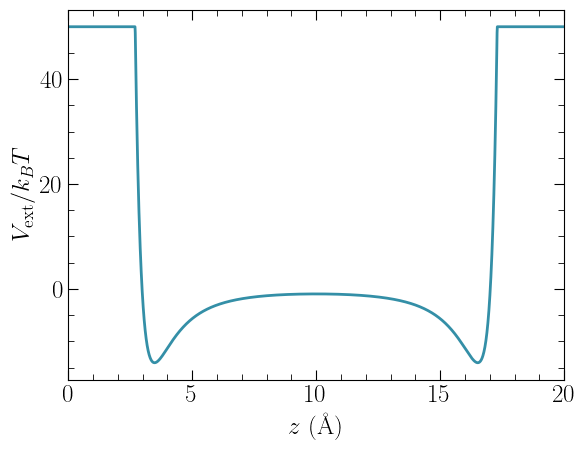

In [37]:
dft.initial_condition(bulk_density[0],Vext,potential_cutoff=50.)
plt.plot(dft.z-5,dft.Vext,color=colors[3],linewidth=2.0)
plt.xlabel(r'$z$ (\AA{})', fontsize=18)
plt.ylabel(r'$V_{\mathrm{ext}}/k_BT$', fontsize=18)
plt.xlim(0.0,H)
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)

In [38]:
Nads = torch.empty_like(P)
Ndes = torch.empty_like(P) 
Omega_ads = torch.empty_like(P)
Omega_des = torch.empty_like(P)

for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2,dt=0.02,tol=1e-6,max_it=20000,logoutput=False)
    Nads[i] = dft.total_molecules 
    Omega_ads[i] = dft.Omega
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())   
    if np.isnan(dft.error.numpy()): break

144 7.282719680630608e-07 1.0000000000000001e-07 9.943180000860437e-06
92 1.5466601194996927e-07 1.2638482029342972e-07 1.2567912826809715e-05
92 1.6149299612031437e-07 1.597312280060256e-07 1.5885953186574407e-05
92 1.70300342124687e-07 2.0187602546790392e-07 2.008065990942969e-05
92 1.817160743733751e-07 2.551406520031288e-07 2.5384062364186738e-05
92 1.9659419242040098e-07 3.224590545296398e-07 3.2089843396069763e-05
92 2.16109006319961e-07 4.075392965871778e-07 4.056986649152439e-05
92 2.4189256571253755e-07 5.150678076168122e-07 5.1295220347675764e-05
92 2.7623607803306605e-07 6.509675230458164e-07 6.486306785643818e-05
92 3.2238511568587734e-07 8.227241341700474e-07 8.203098441810462e-05
92 3.849693171219658e-07 1.03979841848149e-06 0.00010376100981611392
92 4.706192254441098e-07 1.3141473626117582e-06 0.00013127637934673262
92 5.888283349758427e-07 1.660882782627717e-06 0.0001661349360233487
92 7.530996492411191e-07 2.0991037201085544e-06 0.00021032470051614912
92 9.823261124957

In [ ]:
Ndes[-1] = dft.total_molecules
Omega_des[-1] = dft.Omega
for i in range(len(P)-2,-1,-1):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2,dt=0.02,tol=1e-9,max_it=20000,logoutput=False)
    Ndes[i] = dft.total_molecules 
    Omega_des[i] = dft.Omega
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Ndes[i].numpy())   
    if np.isnan(dft.error.numpy()): break

In [ ]:
Neq = np.copy(Nads)
Omega_eq = np.copy(Omega_ads)
for i in range(len(P)):
    if Omega_des[i] < Omega_ads[i]:
        Omega_eq[i] = Omega_des[i]
        Neq[i] = Ndes[i]

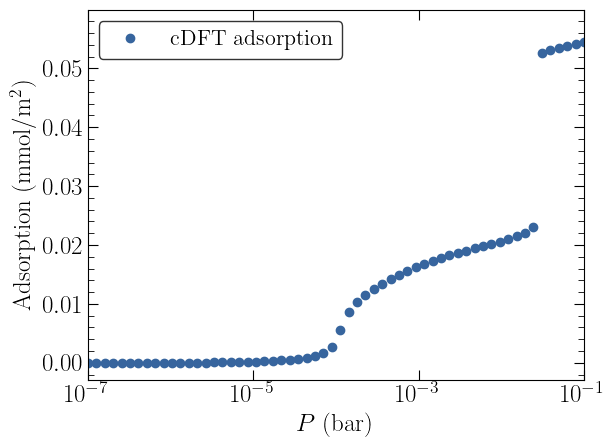

In [39]:
plt.plot(P*1e-5, (1e23/NA)*Nads, 'o', color=colors[2], linewidth=2.0, label='cDFT adsorption')
# plt.plot(P*1e-5, (1e23/NA)*Ndes, '--', color=colors[2], linewidth=2.0, label='cDFT desorption')
# plt.plot(P*1e-5, (1e23/NA)*Neq, ':', color=colors[2], linewidth=2.0, label='cDFT equilibrium')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'Adsorption (mmol/m$^2$)', fontsize=18)
plt.xlim([1e-7,1e-1])
# plt.ylim([0.0,2000])
plt.xscale('log')
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [ ]:
colors = sns.color_palette("mako")

plt.plot(P*1e-5, Omega_ads, '-', color=colors[2], linewidth=2.0, label='adsorption')
plt.plot(P*1e-5, Omega_des, '--', color=colors[2], linewidth=2.0, label='desorption')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$\Omega/k_B T$', fontsize=18)
plt.xlim([-0.01,0.2])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')